In [1]:
import jax.numpy as jnp
from turbulent_propagation import turbulent_propagation, hill_andrews_spectrum, atmospheric_coherence_length, rytov_variance
import matplotlib.pyplot as plt
from jax import random

In [2]:
def gaussian_beam(x, y, z, w0, wavelength):
    zr = jnp.pi * w0**2 / wavelength
    w = w0 * jnp.sqrt(1 + (z / zr) ** 2)
    if z == 0:
        R = jnp.inf
    else:
        R = z * (1 + (zr / z) ** 2)
    psi = jnp.arctan(z / zr)
    r2 = x**2 + y**2
    k = 2 * jnp.pi / wavelength
    return (w0 / w) * jnp.exp(-r2 / w**2 - 1j * (k * r2 / 2 / R - psi))

In [37]:
L = 0.6
N = 256  # Number of points in each dimension
dx = dy = L / N
wavelength = 633e-9  # Wavelength of the wave
w0 = 0.15

xs = jnp.arange(-L / 2, L / 2, dx)
ys = jnp.arange(-L / 2, L / 2, dy)
xs, ys = jnp.meshgrid(xs, ys)
u0 = gaussian_beam(xs, ys, 0, w0, wavelength)

L = 7000

Cn2 = 1e-15
r0 = atmospheric_coherence_length(L, Cn2, wavelength)
L0 = 50
l0 = 0.001

s2 = rytov_variance(L, Cn2, wavelength)
Lambda0 = wavelength * L / jnp.pi / w0**2
w  = w0 * jnp.sqrt(1+Lambda0**2)
Lambda = wavelength * L / jnp.pi / w**2

print("Rytov variance: ", s2)
print("Final waist: ", w)
print("Second turbulence condition: ", s2 * Lambda**(5/6))

Rytov variance:  2.0051969538667658
Final waist:  0.15029442
Second turbulence condition:  0.19878285


In [27]:
u = turbulent_propagation(u0, dx, dy, L, wavelength, 1, hill_andrews_spectrum, key=random.key(42), nsamples=1000, nsteps=10, r0=r0, L0=L0, l0=l0)

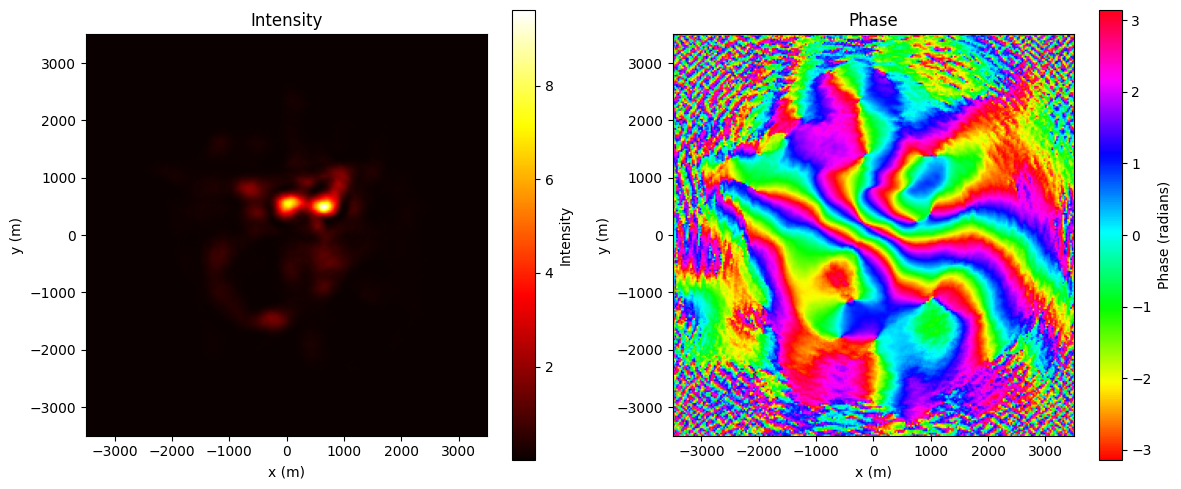

In [28]:
intensities = jnp.abs(u)**2
phases = jnp.angle(u)

idx = 2

# Create subplots to show intensity and phase side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Display intensity
im1 = ax1.imshow(intensities[idx], cmap='hot', extent=[-L/2, L/2, -L/2, L/2])
ax1.set_title('Intensity')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
plt.colorbar(im1, ax=ax1, label='Intensity')

# Display phase
im2 = ax2.imshow(phases[idx], cmap='hsv', extent=[-L/2, L/2, -L/2, L/2])
ax2.set_title('Phase')
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')
plt.colorbar(im2, ax=ax2, label='Phase (radians)')

plt.tight_layout()
plt.show()

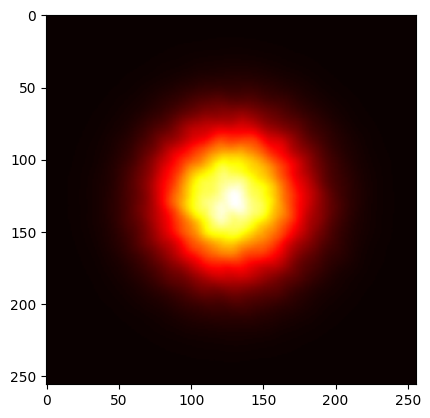

In [29]:
mean_intensity = jnp.mean(intensities, axis=0)
plt.imshow(mean_intensity, cmap='hot')

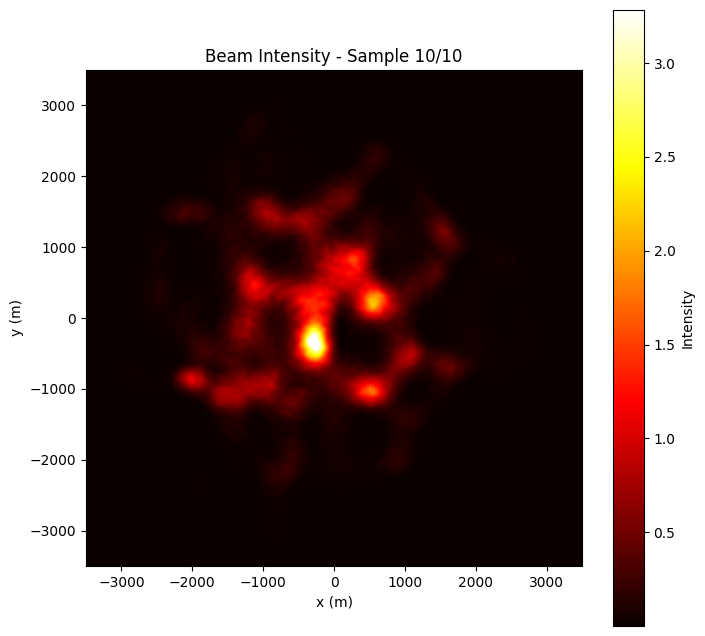

In [22]:
import matplotlib.animation as animation
from IPython.display import HTML

# Create animation of beam intensities
fig, ax = plt.subplots(figsize=(8, 8))

# Calculate intensity (squared magnitude) for all beams
intensities = jnp.abs(u)**2

# Set up the initial plot
im = ax.imshow(intensities[0], cmap='hot', extent=[-L/2, L/2, -L/2, L/2])
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_title('Beam Intensity Animation')
plt.colorbar(im, label='Intensity')

def animate(frame):
    """Animation function to update the plot for each frame"""
    im.set_array(intensities[frame])
    ax.set_title(f'Beam Intensity - Sample {frame+1}/{len(intensities)}')
    return [im]

# Create animation
anim = animation.FuncAnimation(fig, animate, frames=len(intensities), 
                             interval=100, blit=True, repeat=True)

# Display the animation in the notebook
HTML(anim.to_jshtml())

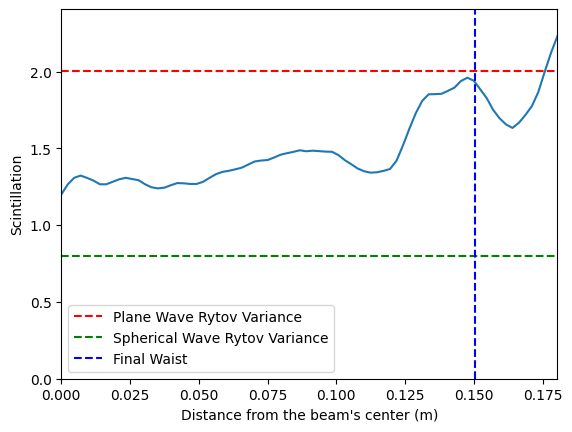

In [43]:
scintilation = jnp.mean(intensities**2, axis=0) / mean_intensity**2 - 1

xmin = 0
xmax = 1.2 * w
ymin = 0
ymax = 1.2 * s2

plt.plot(xs[N//2, N//2:], scintilation[N//2, N//2:])
plt.hlines(s2, color='r', linestyle='--', label='Plane Wave Rytov Variance', xmin=xmin, xmax=xmax)
plt.hlines(0.4 * s2, color='g', linestyle='--', label='Spherical Wave Rytov Variance', xmin=xmin, xmax=xmax)
plt.vlines(w, color='b', linestyle='--', label='Final Waist', ymin=ymin, ymax=ymax)

plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.xlabel("Distance from the beam's center (m)")
plt.ylabel("Scintillation")

plt.legend(loc='lower left')
plt.show()